# Imports

In [52]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle

# Dataset Loader

In [53]:
# get path from config.json
with open('config.json') as f:
    config = json.load(f)

# Define paths to the image and annotation folders
train_img_folder = config['train']['train_img_folder']
train_ann_folder = config['train']['train_ann_folder']
labels_path = config['train']['label_files']

In [54]:
class DatasetLoader:
    def __init__(self, img_folder, ann_folder, target_size=(224, 224)):
        self.img_folder = img_folder
        self.ann_folder = ann_folder
        self.target_size = target_size
        self.images = []
        self.annotations = []
    
    def load_dataset(self):
        # Iterate through each annotation file in the "ann" folder
        for ann_file in os.listdir(self.ann_folder):
            if ann_file.endswith('.json'):
                # Extract image filename from annotation filename
                img_filename = ann_file[:-5]  # Remove the last 5 characters (".json")

                # Load the corresponding image using PIL Image
                img_path = os.path.join(self.img_folder, img_filename)
                img = Image.open(img_path)
                
                # Load the annotation data from the JSON file
                with open(os.path.join(self.ann_folder, ann_file), 'r') as f: # r is for read
                    ann_data = json.load(f)
                
                # Extract bounding box coordinates and class labels
                boxes = []
                labels = []

                # for each object in the annotation file
                # extract the coordinates and classTitle
                for obj in ann_data['objects']:
                    xmin, ymin = obj['points']['exterior'][0] # bottom left corner
                    xmax, ymax = obj['points']['exterior'][1] # top right corner

                    # append the coordinates and classTitle to the boxes and labels lists
                    boxes.append([xmin, ymin, xmax, ymax]) 
                    labels.append(obj['classTitle'])
                
                # For every image, append image and annotations to the lists created in the __init__ method
                self.images.append(img) # in PIL Image format
                self.annotations.append({'boxes': boxes, 'labels': labels}) # in dictionary format

        # Display the number of images loaded
        print(f"Number of images loaded: {len(self.images)}")

    def resize_images(self):
        resized_images = []
        for img in self.images:
            resized_img = img.resize(self.target_size)
            resized_images.append(resized_img)
        self.images = resized_images

    def show_image_with_boxes(self, idx=None):

        if idx is None:
            # Select a random image from the dataset
            # get a random index from the images list
            idx = random.randint(0, len(self.images) - 1) 
        img = self.images[idx]
        annotations = self.annotations[idx]
        
        # Plot the image
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        # Get the current Axes instance on the current figure 
        # gca stands for get current axis
        ax = plt.gca()
        # ax is used to add patches to the image (e.g. bounding boxes, labels, etc.)
        
        # Plot bounding boxes

        # for each box and label in the annotations dictionary
        for box, label in zip(annotations['boxes'], annotations['labels']):
            # unpack the box coordinates
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            # create a Rectangle patch using matplotlib.patches
            rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='b', facecolor='none')
            # add the rectangle to the Axes instance
            ax.add_patch(rect)
            # add a label to the rectangle
            plt.text(xmin, ymin, label, fontsize=10, color='r', verticalalignment='top', backgroundcolor='blue')
            #plt.text(xmin + 0.5 * width, ymin - 3, label, fontsize=10, color='r', ha='right', backgroundcolor='white')
        
        plt.axis('off')
        plt.show()

In [55]:
# train set loader
train_loader = DatasetLoader(train_img_folder, train_ann_folder)
train_loader.load_dataset()

Number of images loaded: 2246


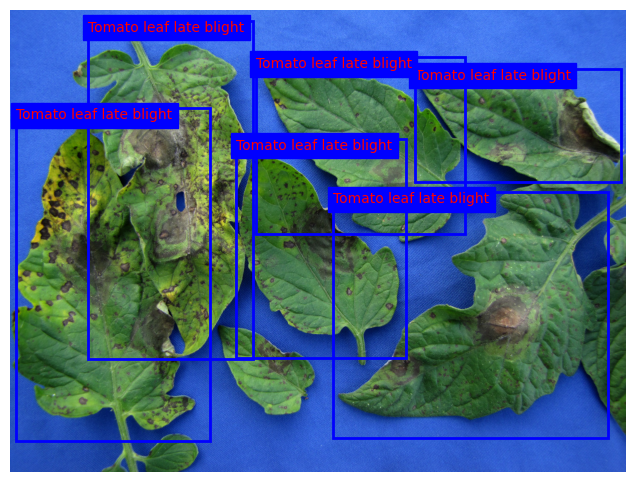

In [56]:
# show random image with bounding boxes
train_loader.show_image_with_boxes()

In [57]:
# print annotations
print(train_loader.annotations[1])

{'boxes': [[761, 115, 1987, 1591], [1478, 565, 2573, 1943]], 'labels': ['Bell_pepper leaf spot', 'Bell_pepper leaf spot']}


# Preprocessing

In [58]:
def extract_class_names(annotations):
    class_names = set()  # Using a set to collect unique class names

    for annotation in annotations:
        labels = annotation['labels']
        class_names.update(labels)  # Add all labels to the set

    class_names = list(class_names)  # Convert set to list
    return class_names

In [59]:
# get class names
class_names = extract_class_names(train_loader.annotations)
# replace space with underscore
#class_names = [name.replace(' ', '_') for name in class_names]
print(class_names)
print(len(class_names))

['Strawberry leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Squash Powdery mildew leaf', 'Tomato Early blight leaf', 'Apple leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf', 'Apple Scab Leaf', 'Tomato leaf yellow virus', 'grape leaf black rot', 'Apple rust leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Tomato two spotted spider mites leaf', 'Raspberry leaf', 'Corn leaf blight', 'Potato leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Peach leaf', 'Tomato mold leaf', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'grape leaf', 'Bell_pepper leaf', 'Soyabean leaf', 'Corn rust leaf']
29


In [60]:
# convert class names to class indices
class_indices = {cls: idx for idx, cls in enumerate(class_names)}
print(class_indices)

{'Strawberry leaf': 0, 'Potato leaf early blight': 1, 'Potato leaf late blight': 2, 'Squash Powdery mildew leaf': 3, 'Tomato Early blight leaf': 4, 'Apple leaf': 5, 'Tomato Septoria leaf spot': 6, 'Tomato leaf bacterial spot': 7, 'Tomato leaf': 8, 'Apple Scab Leaf': 9, 'Tomato leaf yellow virus': 10, 'grape leaf black rot': 11, 'Apple rust leaf': 12, 'Cherry leaf': 13, 'Corn Gray leaf spot': 14, 'Tomato two spotted spider mites leaf': 15, 'Raspberry leaf': 16, 'Corn leaf blight': 17, 'Potato leaf': 18, 'Bell_pepper leaf spot': 19, 'Blueberry leaf': 20, 'Peach leaf': 21, 'Tomato mold leaf': 22, 'Tomato leaf late blight': 23, 'Tomato leaf mosaic virus': 24, 'grape leaf': 25, 'Bell_pepper leaf': 26, 'Soyabean leaf': 27, 'Corn rust leaf': 28}


In [65]:
class Preprocess:
    def __init__(self, images, annotations, ann_folder, img_folder):
        self.images = images
        self.annotations = annotations
        self.ann_folder = ann_folder
        self.img_folder = img_folder

    def resize_images(self, size=(416, 416)):
        resized_images = []
        for image in self.images:
            resized_image = image.resize(size)
            resized_images.append(resized_image)
        print("UPDATE: Images resized to 416x416!")
        return resized_images

    def normalize_images(self, images):
        print("UPDATE: Normalizing images...")
        for img in self.images:
            np_img = np.array(img)
            normalized_np_img = np_img / 255.0
        print("UPDATE: Images normalized!")
        return normalized_np_img
    
    # create labels folder containing .txt files
    # each .txt file contains the class label and bounding box coordinates
    def create_labels(self, labels_folder, target_size=(416, 416), class_indices= class_indices):
        for ann_file, img_, ann in zip(os.listdir(self.ann_folder), os.listdir(self.img_folder), self.annotations):
            print(img_)
            # Extract image filename from the img_folder
            if img_.endswith('.jpg'):
                img_filename = img_[:-4]  # Remove the last 4 characters (".jpg")
            elif img_.endswith('.png'):
                img_filename = img_[:-4]  # Remove the last 4 characters (".png")
            elif img_.endswith('.jpeg'):
                img_filename = img_[:-5]
            else:
                img_filename = img_[:-4]

            # Create a new .txt file with the same name as the image
            filename = img_filename + '.txt'
            print("-> " , img_filename)
            with open(os.path.join(labels_folder, filename), 'w') as f:
                for box, label in zip(ann['boxes'], ann['labels']):
                    # unpack the box coordinates
                    xmin, ymin, xmax, ymax = box
                    # normalize the coordinates
                    x = (xmin + xmax) / 2.0 / target_size[0]
                    y = (ymin + ymax) / 2.0 / target_size[1]
                    width = (xmax - xmin) / target_size[0]
                    height = (ymax - ymin) / target_size[1]
                    # get class index from class_indices dictionary
                    label = class_indices[label]
                    # remove any spaces from the label
                    #label = label.replace(" ", "_")
                    # write the label and normalized coordinates to the file
                    f.write(f"{label} {x} {y} {width} {height}\n")
        print("UPDATE: Labels created succesfully!")

In [66]:
pp = Preprocess(train_loader.images, train_loader.annotations, train_ann_folder, train_img_folder)

In [67]:
#resized_images = pp.resize_images()

In [68]:
#normalized_np_img = pp.normalize_images(resized_images)

In [69]:
pp.create_labels(labels_path)

0.jpg
->  0
0000.jpg
->  0000
00009.jpg
->  00009
0008003-strawberry-leaf-veiner-large.jpg
->  0008003-strawberry-leaf-veiner-large
000g.jpg
->  000g
000gb.jpg
->  000gb
003.JPG.jpg
->  003.JPG
004-10.jpg
->  004-10
0042241.jpg
->  0042241
0052.jpg
->  0052
0061.jpg
->  0061
007.JPG.jpg
->  007.JPG
009-e1373768789869.jpg
->  009-e1373768789869
00c.jpg
->  00c
00gb.jpg
->  00gb
011.jpg
->  011
01c.jpg
->  01c
01gb.jpg
->  01gb
02.jpg
->  02
02.JPG.jpg
->  02.JPG
020.JPG.jpg
->  020.JPG
022.jpg
->  022
02b13cea19417b15cf3d6ff534aa7ea653ad783094a60_1260x1260.jpg
->  02b13cea19417b15cf3d6ff534aa7ea653ad783094a60_1260x1260
02gb.jpg
->  02gb
03.jpg
->  03
03c.jpg
->  03c
04.jpg
->  04
04c.jpg
->  04c
05-069f1.jpg
->  05-069f1
05-069f12.jpg
->  05-069f12
05-069f9.jpg
->  05-069f9
05.jpg
->  05
05c.jpg
->  05c
06.jpg
->  06
06c.jpg
->  06c
071409%20Vincelli%20nlb%20on%20corn%20leaf.JPG.jpg
->  071409%20Vincelli%20nlb%20on%20corn%20leaf.JPG
072.jpg
->  072
072109%20Hartman%20Grape%20black%20rot

# get the class names

In [1]:
!cd C:\Users\kruth\leaf_disease_detection\yolov5 && python train.py --img 416 --batch 16 --epochs 200 --data data.yaml --cfg models/yolov5s.yaml --weights '' --name leaf_detect

^C


In [19]:
# do for test
test_img_folder = config['test']['test_img_folder']
test_ann_folder = config['test']['test_ann_folder']
labels_path = config['test']['label_files']

In [20]:
# test set loader
test_loader = DatasetLoader(test_img_folder, test_ann_folder)
test_loader.load_dataset()

Number of images loaded: 231


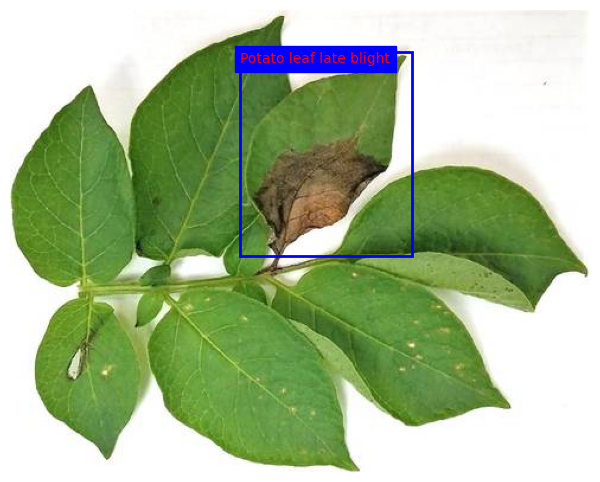

In [21]:
# show random image with bounding boxes
test_loader.show_image_with_boxes()

In [22]:
# get class names
class_names_test = extract_class_names(test_loader.annotations)
# replace space with underscore
#class_names_test = [name.replace(' ', '_') for name in class_names_test]
print(class_names_test)
print(len(class_names_test))

['Strawberry leaf', 'Potato leaf early blight', 'Apple leaf', 'Potato leaf late blight', 'Tomato Early blight leaf', 'Squash Powdery mildew leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf', 'Apple Scab Leaf', 'Tomato leaf yellow virus', 'grape leaf black rot', 'Apple rust leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Raspberry leaf', 'Corn leaf blight', 'Bell_pepper leaf spot', 'Tomato leaf mosaic virus', 'Peach leaf', 'Tomato mold leaf', 'Tomato leaf late blight', 'Blueberry leaf', 'grape leaf', 'Bell_pepper leaf', 'Soyabean leaf', 'Corn rust leaf']
27


In [23]:
# convert class names to class indices
class_indices = {cls: idx for idx, cls in enumerate(class_names)}
print(class_indices)

{'Strawberry leaf': 0, 'Potato leaf early blight': 1, 'Potato leaf late blight': 2, 'Squash Powdery mildew leaf': 3, 'Tomato Early blight leaf': 4, 'Apple leaf': 5, 'Tomato Septoria leaf spot': 6, 'Tomato leaf bacterial spot': 7, 'Tomato leaf': 8, 'Apple Scab Leaf': 9, 'Tomato leaf yellow virus': 10, 'grape leaf black rot': 11, 'Apple rust leaf': 12, 'Cherry leaf': 13, 'Corn Gray leaf spot': 14, 'Tomato two spotted spider mites leaf': 15, 'Raspberry leaf': 16, 'Corn leaf blight': 17, 'Potato leaf': 18, 'Bell_pepper leaf spot': 19, 'Blueberry leaf': 20, 'Peach leaf': 21, 'Tomato mold leaf': 22, 'Tomato leaf late blight': 23, 'Tomato leaf mosaic virus': 24, 'grape leaf': 25, 'Bell_pepper leaf': 26, 'Soyabean leaf': 27, 'Corn rust leaf': 28}


In [27]:
# preprocess test set
pp = Preprocess(test_loader.images, test_loader.annotations, test_ann_folder, test_img_folder)

In [28]:
pp.create_labels(labels_path)

%2320+Bacterial+Spot+and+Speck
0
00
000
0000
00pe
01
02.-Rust-2017-207u24s
02c
039b47d574bc4bb8a14259a1cd96a741
03gb
052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG
0605_Rust-induced_leafspot
07.17.18-Common_Tomato_Diseases_Canker-258x300
0796.20graylssymt
0796.39maizerust
0796.40comrust
0796.47southrust
0796.52srusttelia
07c
07feb_ma_sbr3.JPG
0c
100983448
10148582-green-leaf-of-pepper
11-40580_5
110822-206-Tomato-blight
12-19striprustJIM
1234080-Early-Blight
1321189
1355.50commonrust
160314_web
1684
17fc47
185161-004-EAF28842
18c
1b321015-6e33-4f18-aade-888f4383fe92.jpeg
20090710-lateblight
2011-011
2013-08-20-06
20130519cedarapplerust
20130610_110514
20130802_111632
2013Corn_GrayLeafSpot_0815_0003.JPG
2015070295153021
20180511_090912-14gtw8a-e1526047952754
20180511_091133-24l1vhg-e1526047988236
20180511_091252-1gy5xf5-e1526048000596
2256-body-1501555581-1
2540_600
28-500x375
2septoria-tomato
2STEM
3023
35589125035_662dd5b258_b
393
4-apple-rust2_19011_matt-bertone
4120978-sing

In [26]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

1
NVIDIA GeForce RTX 3050 Laptop GPU
